In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns; sns.set(style="white", font_scale=2)

import numpy as np
import pandas as pd
from astropy.io import fits
import glob

import sklearn
import sklearn.metrics

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.noise import GaussianNoise

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import random_channel_shift
from keras.optimizers import SGD, Adam
from keras import backend as K
K.set_image_data_format('channels_first')
K.set_session(K.tf.Session(config=K.tf.ConfigProto(intra_op_parallelism_threads=10, 
                                                   inter_op_parallelism_threads=10)))

import scipy.ndimage as ndi

import matplotlib.patches as patches

import pathlib


Using TensorFlow backend.


In [2]:
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = np.array((10,6))*.6
mpl.rcParams['figure.facecolor'] = "white"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# my modules that are DNN specific
import os, sys
dwarfz_package_dir = pathlib.Path \
                            .cwd() \
                            .parent / "DNN"

if str(dwarfz_package_dir) not in sys.path:
    sys.path.insert(0, str(dwarfz_package_dir))
    sys.path.insert(0, str(dwarfz_package_dir.parent.parent))
                    
import dwarfz

# these actually exist in "../DNN" which is why I had to add it to the path above
import preprocessing
import geometry

# To Do
 1. Read in fits images
 2. Apply pre-processing stretch (asinh)
 3. crop image smaller
 4. Combine filters into one cube
 5. Create training set with labels
 6. Set up keras model
 7. Poke around at the results
 
 

# 0) Get files

In [5]:
# images_dir = pathlib.Path(preprocessing.images_dir)
images_dir = pathlib.Path.home() / "dwarfz" / "galaxies_narrowband"
images_dir

PosixPath('/Users/egentry/dwarfz/galaxies_narrowband')

In [6]:
HSC_ids_target = {int(subdir.name)
                  for subdir in images_dir.glob("target/*")
                  if subdir.name[0] != "."}

HSC_ids_contaminant = {int(subdir.name)
                       for subdir in images_dir.glob("contaminant/*")
                       if subdir.name[0] != "."}

remove_ids = HSC_ids_target & HSC_ids_contaminant
HSC_ids_target -= remove_ids
HSC_ids_contaminant -= remove_ids

HSC_ids = HSC_ids_target | HSC_ids_contaminant

HSC_ids_target      = np.array(list(HSC_ids_target))
HSC_ids_contaminant = np.array(list(HSC_ids_contaminant))
HSC_ids             = np.array(list(HSC_ids))


print(len(HSC_ids_target))
print(len(HSC_ids_contaminant))
print(len(HSC_ids), len(HSC_ids_target) + len(HSC_ids_contaminant))


HSC_ids = np.array(sorted(HSC_ids)) # enforce a deterministic ordering

6278
18999
25277 25277


In [7]:
HSC_id = HSC_ids[1] # for when I need a single sample galaxy

In [8]:
bands = ["g", "r", "i", "z", "y"]

# 1) Read in fits image


In [9]:
get_image = lambda HSC_id, band: preprocessing.get_image(HSC_id, band, images_dir=images_dir/"*"/str(HSC_id))

In [10]:
image, flux_mag_0 = get_image(HSC_id, "g")
print("image size: {} x {}".format(*image.shape))
image

image size: 239 x 239


array([[-0.02194131,  0.00391446,  0.01770653, ..., -0.01461175,
        -0.01249455,  0.01746454],
       [-0.01601904, -0.02720453, -0.06848946, ...,  0.04288237,
         0.00534859,  0.02132502],
       [-0.01800561, -0.05129848, -0.06990851, ...,  0.03650333,
         0.01508071, -0.03739795],
       ...,
       [ 0.02909144,  0.03687791,  0.04685813, ...,  0.03878131,
        -0.04980357, -0.0178718 ],
       [ 0.01575067, -0.01513606,  0.02736958, ...,  0.01000878,
         0.00148029,  0.01590817],
       [ 0.02265622,  0.04364862, -0.00685509, ..., -0.01821685,
         0.01330067,  0.01832419]], dtype=float32)

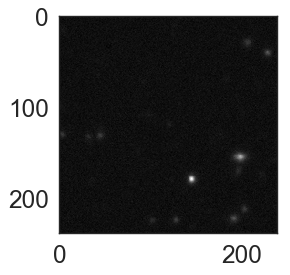

In [11]:
preprocessing.image_plotter(image)

/Users/egentry/anaconda3/envs/tf36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


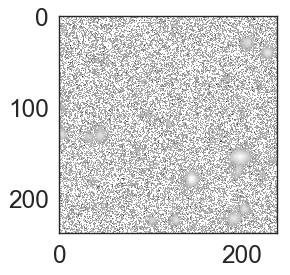

In [12]:
preprocessing.image_plotter(np.log(image))

# 2) Apply stretch

We're using (negative) asinh magnitudes, as implemented by the HSC collaboration.

To see more about asinh magnitude system, see : [Lupton, Gunn and Szalay (1999)](http://iopscience.iop.org/article/10.1086/301004/meta) used for SDSS. (It's expliticly given in the [SDSS Algorithms](http://classic.sdss.org/dr7/algorithms/fluxcal.html) documentation as well as [this overview page](https://ned.ipac.caltech.edu/help/sdss/dr6/photometry.html#asinh)).

To see the source of our code, see: [the HSC color image creator](https://hsc-gitlab.mtk.nao.ac.jp/snippets/23#L172)

And for reference, a common form of this stretch is:
$$ \mathrm{mag}_\mathrm{asinh} = - \left(\frac{2.5}{\ln(10)}\right) \left(\mathrm{asinh}\left(\frac{f/f_0}{2b}\right) + \ln(b) \right)$$
for dimensionless softening parameter $b$, and reference flux (f_0).


In [13]:
def scale(x, fluxMag0):
    ### adapted from https://hsc-gitlab.mtk.nao.ac.jp/snippets/23
    mag0 = 19
    scale = 10 ** (0.4 * mag0) / fluxMag0
    x *= scale

    u_min = -0.05
    u_max = 2. / 3.
    u_a = np.exp(10.)

    x = np.arcsinh(u_a*x) / np.arcsinh(u_a)
    x = (x - u_min) / (u_max - u_min)

    return x


In [14]:
image_scaled = preprocessing.scale(image, flux_mag_0)

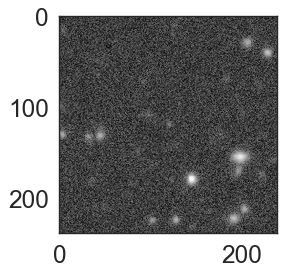

In [15]:
preprocessing.image_plotter(image_scaled)

Text(0.5, 1.0, 'Distribution of Transformed Intensities')

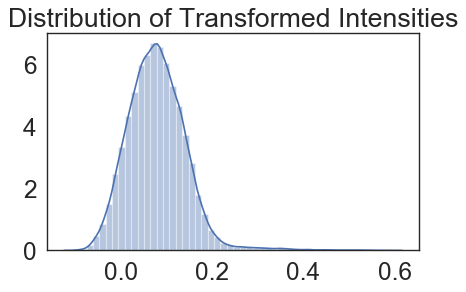

In [16]:
sns.distplot(image_scaled.flatten())
plt.title("Distribution of Transformed Intensities")

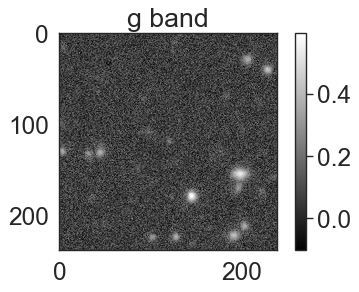

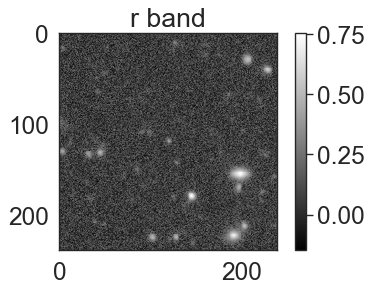

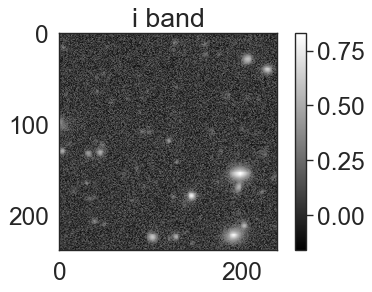

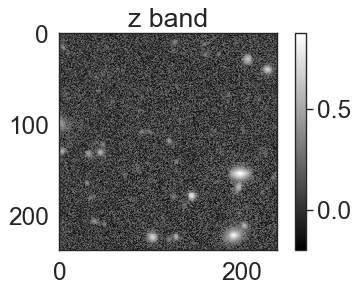

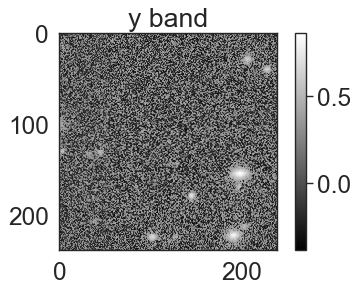

In [17]:
for band in bands:
    image, flux_mag_0 = get_image(HSC_id, band)
    image_scaled = preprocessing.scale(image, flux_mag_0)

    plt.figure()
    preprocessing.image_plotter(image_scaled)
    plt.title("{} band".format(band))
    plt.colorbar()

# 3) Crop Image
Am I properly handling odd numbers?

In [18]:
pre_transformed_image_size  = 150
post_transformed_image_size = 75

In [19]:
cutout = preprocessing.get_cutout(image_scaled, post_transformed_image_size)
cutout.shape

(75, 75)

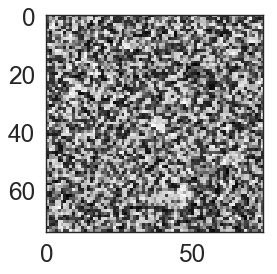

In [20]:
preprocessing.image_plotter(cutout)

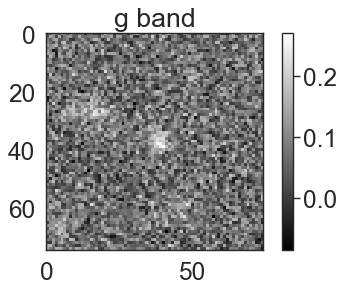

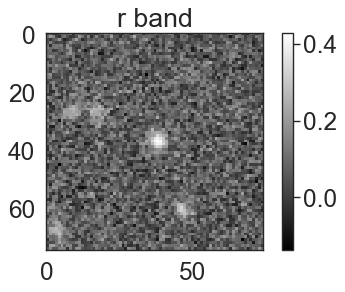

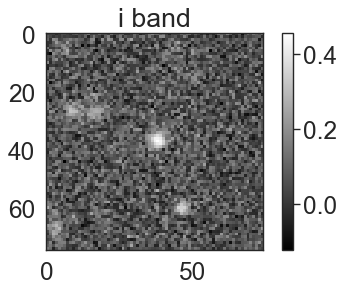

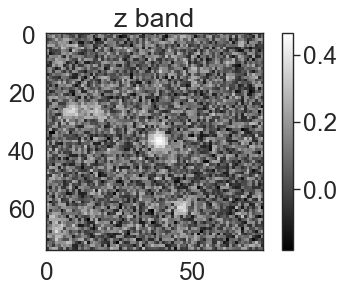

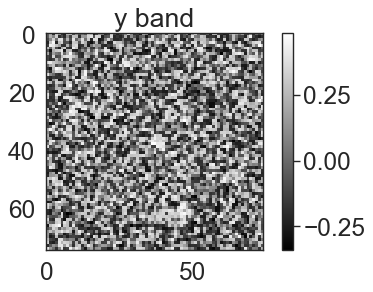

In [21]:
for band in bands:
    image, flux_mag_0 = get_image(HSC_id, band)
    image_scaled = preprocessing.scale(image, flux_mag_0)
    cutout = preprocessing.get_cutout(image_scaled, post_transformed_image_size)

    plt.figure()
    preprocessing.image_plotter(cutout)
    plt.title("{} band".format(band))
    plt.colorbar()

# 4) Combine filters into cube

In [22]:
images = [None]*len(bands)
flux_mag_0s = [None]*len(bands)
cutouts = [None]*len(bands)
for i, band in enumerate(bands):
    images[i], flux_mag_0s[i] = get_image(HSC_id, band)
    
    cutouts[i] = preprocessing.get_cutout(
        preprocessing.scale(images[i], flux_mag_0s[i]), 
        post_transformed_image_size
    )


In [23]:
cutout_cube = np.array(cutouts)
cutout_cube.shape

(5, 75, 75)

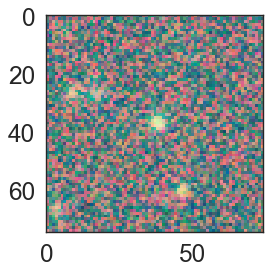

In [24]:
# must transform into [0,1] for plt.imshow
# the HSC standard tool accomplishes this by clipping instead.
plt.imshow(preprocessing.transform_0_1(cutout_cube[(4,2,0),:,:].transpose(1,2,0)) )

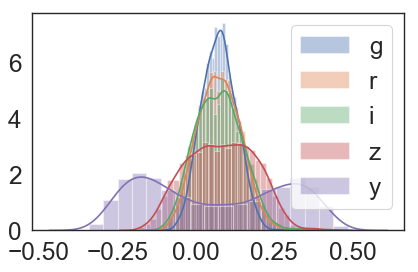

In [25]:
for i, band in enumerate(bands):
    sns.distplot(cutout_cube[:,:,:].transpose(1,2,0)[:,:,i].flatten(), label=band)
    plt.legend(loc="best")

# 5) Load Training Set Labels

In [26]:
df = pd.DataFrame(data={
    "HSC_id" :HSC_ids,
    "target" : [HSC_id in HSC_ids_target for HSC_id in HSC_ids]
})

df = df.set_index("HSC_id")

df.head()

,target
HSC_id,
43158176442354210,False
43158176442354294,False
43158176442354356,False
43158176442354418,True
43158176442354561,False


In [27]:
df.mean()

target    0.248368
dtype: float64

In [28]:
def load_image_mappable(HSC_id):
    images      = [None]*len(bands)
    flux_mag_0s = [None]*len(bands)
    cutouts     = [None]*len(bands)
    for j, band in enumerate(bands):
        images[j], flux_mag_0s[j] = get_image(HSC_id, band)
        cutouts[j] = preprocessing.get_cutout(
            preprocessing.scale(images[j], flux_mag_0s[j]),
            pre_transformed_image_size)
    cutout_cube = np.array(cutouts)
    return cutout_cube

In [29]:
X = np.empty((len(HSC_ids[:400]), 5, 
              pre_transformed_image_size, pre_transformed_image_size))

In [30]:
X.shape

(400, 5, 150, 150)

In [31]:
for i in range(X.shape[0]):
    HSC_id = HSC_ids[i]
    X[i] = load_image_mappable(HSC_id)
    
    if i%(X.shape[0]//20)==0:
        print("loading # {} / {}".format(i, X.shape[0]), end="\r", flush=True)

In [32]:
X_full = X
X_small = X[:,(4,2,0),:,:] # drop down to 3 bands (y, i, g)

In [33]:
X.shape

(400, 5, 150, 150)

In [34]:
Y = df.loc[HSC_ids].target.values
Y

array([False, False, False, ..., False, False, False])

In [35]:
Y.mean()

0.24836808165525973

### load photometric features

In [42]:
COSMOS_filename = pathlib.Path(dwarfz.data_dir_default) / "COSMOS_reference.sqlite"
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

HSC_filename = pathlib.Path(dwarfz.data_dir_default) / "HSC_COSMOS_median_forced.sqlite3"
HSC = dwarfz.datasets.HSC(HSC_filename)

matches_filename = pathlib.Path(dwarfz.data_dir_default) / "matches.sqlite3"
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values
    
    
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

df_frankenz = pd.read_sql_table("photo_z",
                                "sqlite:///{}".format(
                                    pathlib.Path(dwarfz.data_dir_default)
                                                 / "HSC_matched_to_FRANKENZ.sqlite"),
                                index_col="object_id")

df_frankenz.head()

combined = combined.join(df_frankenz[["photoz_best", "photoz_risk_best"]],
                         on="catalog_2_ids")

photometry_features = combined.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                                      "icmodel_mag",
                                      "photoz_best",
                                      "photoz_risk_best" # The risk of photoz_best being outside of the range z_true +- 0.15(1+z_true). It ranges from 0 (safe) to 1(risky)
                                     ]]

photometry_features.head()


,g_minus_r,r_minus_i,i_minus_z,z_minus_y,icmodel_mag,photoz_best,photoz_risk_best
catalog_1_ids,,,,,,,
219656,0.904190,0.614107,-0.192213,-1.643913,25.473045,1.66,0.456715
219741,0.620031,0.076033,-0.445490,0.817816,25.845751,1.60,0.448231
219743,0.749485,0.457653,0.204971,-0.212778,24.897820,0.69,0.145915
219744,0.548159,-0.039301,0.487778,-1.281529,26.055256,3.37,0.351811
219769,-1.042015,-3.360178,4.475088,0.235411,30.648498,0.91,0.680943


In [43]:
training_set_labels_filename = "../data/galaxy_images_training/2017_09_26-dwarf_galaxy_scores.csv"
HSC_to_COSMOS = pd.read_csv(training_set_labels_filename)
HSC_to_COSMOS = HSC_to_COSMOS.drop_duplicates("HSC_id")
HSC_to_COSMOS = HSC_to_COSMOS.set_index("HSC_id")
HSC_to_COSMOS = HSC_to_COSMOS[["COSMOS_id"]]
HSC_to_COSMOS.head()

,COSMOS_id
HSC_id,
43158322471244656,628457
43158605939114836,919771
43159142810013665,444239
43158734788125011,569427
43158863637144621,369948


In [44]:
photometry_features_aligned = photometry_features.loc[HSC_to_COSMOS.loc[HSC_ids].values.flatten()]
photometry_features_aligned.head()

,g_minus_r,r_minus_i,i_minus_z,z_minus_y,icmodel_mag,photoz_best,photoz_risk_best
catalog_1_ids,,,,,,,
387020,0.241915,0.287563,0.580751,-0.461952,25.067200,0.75,0.189435
389379,0.815916,0.300808,0.021614,-0.038185,23.948193,0.36,0.158907
390478,1.774567,1.506727,0.083956,-0.385647,24.193956,0.85,0.183067
391721,0.493143,0.108091,0.332539,0.058878,25.082439,2.61,0.458986
394884,1.182629,0.388001,0.275812,-0.031630,23.426733,0.50,0.168350


# Geometry!

In [45]:
X[0].shape

(5, 150, 150)

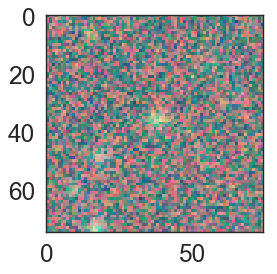

In [46]:
h = pre_transformed_image_size
w = pre_transformed_image_size
transform_matrix = geometry.create_random_transform_matrix(h, w,
                                                  include_rotation=True,
                                                  translation_size = .01,
                                                  verbose=False)

x_tmp = X[0][(4,2,0),:,:]

result = geometry.apply_transform_new(x_tmp, transform_matrix, 
                            channel_axis=0, fill_mode="constant", cval=np.max(x_tmp))

result = preprocessing.get_cutout(x_tmp, post_transformed_image_size)
plt.imshow(preprocessing.transform_0_1(result.transpose(1,2,0)))

In [47]:
import ipywidgets
ipywidgets.interact(preprocessing.transform_plotter,
                    X = ipywidgets.fixed(X_small),
                    rotation_degrees = ipywidgets.IntSlider(min=0, max=360, step=15, value=45),
                    dx_after = ipywidgets.IntSlider(min=-15, max=15),
                    dy_after = ipywidgets.IntSlider(min=-15, max=15),
                    color = ipywidgets.fixed(True),
                    shear_degrees = ipywidgets.IntSlider(min=0, max=90, step=5, value=0),
                    zoom_x = ipywidgets.FloatSlider(min=.5, max=2, value=1),
                    crop = ipywidgets.Checkbox(value=True)
                    )

interactive(children=(Checkbox(value=False, description='reflect_x'), IntSlider(value=45, description='rotatio…

<function preprocessing.transform_plotter(X, reflect_x=False, rotation_degrees=45, dx_after=0, dy_after=0, shear_degrees=0, zoom_x=1, crop=False, color=True)>

## 5b) Split training and testing set

In [48]:
np.random.seed(1)

randomized_indices = np.arange(Y.shape[0])
np.random.shuffle(randomized_indices)

testing_fraction = 0.2
testing_set_indices = randomized_indices[:int(testing_fraction*Y.shape[0])]
training_set_indices = np.array(list(set([*randomized_indices]) - set([*testing_set_indices])))

In [49]:
print(testing_set_indices.size, Y[testing_set_indices].mean())

5055 0.247675568743818


In [50]:
print(training_set_indices.size, Y[training_set_indices].mean())

20222 0.24854119276036


In [51]:
p = Y[training_set_indices].mean()
prior_loss = sklearn.metrics.log_loss(Y[testing_set_indices], 
                                      [p]*testing_set_indices.size)
prior_loss


0.5597690655312428

## 6b) Adapt NumpyArrayIterator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images.

Also, I want to change the way that augmentation is happening

In [52]:
from data_generator_directory import DirectoryIterator

## 6c) Adapt ImageDataGenerator
The original only allowed 1, 3 or 4 channel images. I have 5 channel images. Also, I'm adjusting the way that the affine transformations work for the data augmentation

In [53]:
from data_generator_directory import ImageDataGeneratorLoadable

## 6d) Create Data Generator

In [54]:
print('Using real-time data augmentation.')

h_before, w_before = X[0,0].shape
print("image shape before: ({},{})".format(h_before, w_before))

h_after = post_transformed_image_size
w_after = post_transformed_image_size
print("image shape after:  ({},{})".format(h_after, w_after))

# get a closure that binds the image size to get_cutout
postprocessing_function = lambda image: preprocessing.get_cutout(image, post_transformed_image_size)

# this will do preprocessing and realtime data augmentation
datagen = ImageDataGeneratorLoadable(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    with_reflection_x=True, # randomly apply a reflection (in x)
    with_reflection_y=True, # randomly apply a reflection (in y)
    with_rotation=False, # randomly apply a rotation
    width_shift_range=0.002,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.002,  # randomly shift images vertically (fraction of total height)
    postprocessing_function=postprocessing_function, # get a cutout of the processed image
    output_image_shape=(post_transformed_image_size,post_transformed_image_size)
)   

# this will do preprocessing and realtime data augmentation
from data_generator import ImageDataGenerator
datagen_features = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    with_reflection_x=False, # randomly apply a reflection (in x)
    with_reflection_y=False, # randomly apply a reflection (in y)
    with_rotation=False, # randomly apply a rotation
#     width_shift_range=0.002,  # randomly shift images horizontally (fraction of total width)
#     height_shift_range=0.002,  # randomly shift images vertically (fraction of total height)
#     postprocessing_function=postprocessing_function, # get a cutout of the processed image
    output_image_shape=(1,1),
)   

Using real-time data augmentation.
image shape before: (150,150)
image shape after:  (75,75)


In [55]:
# datagen.fit()

# 7) Set up `keras` model

In [56]:
with_one_by_one = False
trainable = False

input_shape = cutout_cube.shape

nb_dense = 64

In [57]:
from keras.applications import inception_v3, inception_resnet_v2, vgg19

In [79]:
feature_extractor = Sequential()
extractor_input_shape = tuple([3, *input_shape[1:]])
extractor_layers = vgg19.VGG19(include_top=False,
                                input_shape=extractor_input_shape
                               )
for layer in extractor_layers.layers:
    layer.trainable = False
feature_extractor.add(extractor_layers)

feature_extractor.compile(optimizer= Adam(lr=1),
               loss="mean_squared_error")

In [59]:
reextract_features = False
features_filename = "vgg_features.h5"

if reextract_features or (not pathlib.Path(features_filename).is_file()):
    
    features = np.zeros((Y.size, 512, 2, 2))
    for i, HSC_id in enumerate(HSC_ids):
        x_tmp = np.array([datagen.standardize(load_image_mappable(HSC_id))])
        features[i] = feature_extractor.predict(x_tmp[:,(4,2,0),:,:])

        if i%(features.shape[0]//20)==0:
            print("loading # {} / {}".format(i, features.shape[0]), end="\r", flush=True)
    df_vgg = pd.DataFrame(data={
        "HSC_id" : HSC_ids,
        "vgg_features" : [feature_row for feature_row in features]
    })
#     df_vgg.to_hdf(features_filename, "data")
else:
    df_vgg = pd.read_hdf(features_filename)
    features = np.array([row for row in df_vgg.vgg_features.values])    
features.shape

(25277, 512, 2, 2)

In [60]:
learning_rate = 0.00025
decay = 1e-5
momentum = 0.9

# sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

adam = Adam(lr=learning_rate)

In [137]:
!head training_transfer.log.old

In [134]:
logger_filename = "training_transfer"
if trainable:
    logger_filename += "-trainable" 
if with_one_by_one:
    logger_filename += "-1x1"
logger_filename += ".log"


# model.compile(loss='binary_crossentropy', 
# #               optimizer=sgd, 
#               optimizer=adam,
# #               metrics=["accuracy"]
#              )

# can only manually set weights _after_ compiling
# one_by_one_weights = np.zeros((1,1,5,3))
# for i in range(3):
#     one_by_one_weights[0,0,4-2*i,i] = 1 # chooses y i g with correct color order
# one_by_one.set_weights([one_by_one_weights,
#                         np.zeros(3)])

print("using logger_filename: ", logger_filename)

# if os.path.exists(logger_filename):
#     logger_filename_tmp = logger_filename + ".old"
#     os.rename(logger_filename, logger_filename_tmp)


using logger_filename:  training_transfer.with_photometry.log


In [109]:
features_combined.shape

(25277, 2055)

In [123]:
model = Sequential()
model.add(Flatten(input_shape=(np.prod(features.shape[1:]) + photometry_features.shape[1], 1, 1)))
model.add(Dense(2*nb_dense, activation="relu"))
model.add(Dense(nb_dense, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer= Adam(lr=learning_rate),
               loss="binary_crossentropy")

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2055)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               263168    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 271,489
Trainable params: 271,489
Non-trainable params: 0
_________________________________________________________________


In [124]:
earlystopping = EarlyStopping(monitor='loss',
                              patience=35,
                              verbose=1,
                              mode='auto' )


In [125]:
csv_logger = keras.callbacks.CSVLogger(logger_filename,
                                       append=True)

# 8) Run basic keras model

In [126]:
goal_batch_size = 128
steps_per_epoch = max(2, training_set_indices.size//goal_batch_size)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epoch_to_save_state = 50
epochs = 100
verbose = 1

steps_per_epoch:  157
batch_size:  128


In [127]:
prior_loss

0.5597690655312428

In [128]:
features_combined = np.hstack([features.reshape(-1, 512*2*2), photometry_features_aligned])
features_combined = features_combined.reshape(*features_combined.shape, 1, 1)
print(features_combined.shape)

(25277, 2055, 1, 1)


In [174]:
epochs=200


args = (datagen_features.flow(features_combined[training_set_indices], 
                              Y[training_set_indices],
                              batch_size=batch_size,
                             ),
       )

kwargs = dict(steps_per_epoch=steps_per_epoch,
              validation_data=(features_combined[testing_set_indices], 
                               Y[testing_set_indices]),
              verbose=verbose,
              callbacks=[csv_logger],
             )

for epoch_i in range(epochs):
    history = model.fit_generator(*args,
                                  initial_epoch=epoch_i,
                                  epochs=epoch_i+1,
                                  **kwargs,
                                  )

    model.save_weights("weights/cached_weights.extracted_features.with_photometry.{:>04d}.h5".format(epoch_i))


Epoch 1/1
  2/157 [..............................] - ETA: 20:53 - loss: 0.4380

KeyboardInterrupt: 

In [62]:
# logged_history = pd.read_csv(logger_filename)
logged_history = pd.read_csv("training_transfer.log")

logged_history

,epoch,loss,val_loss
0,0,0.561169,0.559210
1,1,0.556649,0.557379
2,2,0.553965,0.550001
3,3,0.551831,0.546692
4,4,0.548141,0.552239
5,5,0.546731,0.542289
6,6,0.545093,0.540325
7,7,0.545430,0.539295
8,8,0.542962,0.542445
9,9,0.541900,0.549355


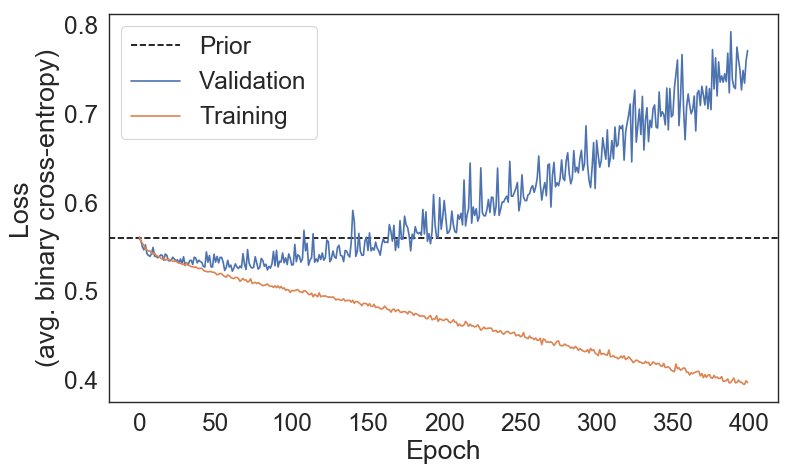

In [63]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

        
    plt.axhline(prior_loss, label="Prior", 
                linestyle="dashed", color="black")
    
    plt.plot(logged_history["val_loss"], label="Validation")
    plt.plot(logged_history["loss"], label="Training")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss\n(avg. binary cross-entropy)")
    
    plt.legend()
    
#     plt.ylim(bottom=.56, top=.62)

    plt.tight_layout()
    plot_filename = pathlib.Path("plots_for_thesis") / "learning_curve-with_photometry"
    plt.savefig(plot_filename.with_suffix(".png"))
    plt.savefig(plot_filename.with_suffix(".pdf"))
    

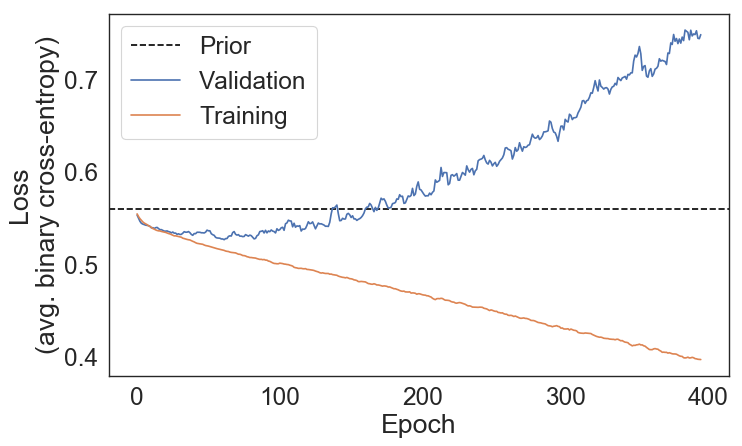

In [64]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

    simple_conv = lambda x: np.convolve(x, np.ones(5)/5, mode="valid")
    
    plt.axhline(prior_loss, label="Prior", 
                linestyle="dashed", color="black")
    
    plt.plot(simple_conv(logged_history["val_loss"]),
             label="Validation")
    plt.plot(simple_conv(logged_history["loss"]),
             label="Training")
    
    plt.xlabel("Epoch")
    plt.ylabel("Loss\n(avg. binary cross-entropy)")
    
    plt.legend()
    
#     plt.ylim(bottom=.56, top=.62)



# 9) Look at validation results

In [165]:
color_CNN = "b"

linestyle_CNN = "solid"

linewidth=3

In [150]:
overwrite = True
use_cached_if_exists = False
class_probs_filename = "class_probs.with_photometry.csv"

if use_cached_if_exists and pathlib.Path(class_probs_filename).is_file():
    df_class_probs = pd.read_csv(class_probs_filename)
else:
    X_transformed = np.array([datagen.standardize(X_img)
                              for X_img in X])
    class_probs = model3.predict_proba(features_combined).flatten()
    
    df_class_probs = pd.DataFrame({
        "HSC_id": HSC_ids,
        "CNN_prob": class_probs,
        "testing": [HSC_id in HSC_ids[testing_set_indices] for HSC_id in HSC_ids],
        "target": Y,
    })

    if overwrite or (not pathlib.Path(class_probs_filename).is_file()):
        df_class_probs.to_csv(class_probs_filename, index=False)


df_testing = df_class_probs[df_class_probs.testing]

df_class_probs.head()


In [173]:
print(df_class_probs.target.mean())
print(df_class_probs[~df_class_probs.testing].target.mean())

print(df_testing.CNN_prob.mean())

0.24836808165525973
0.24854119276036
0.1659968


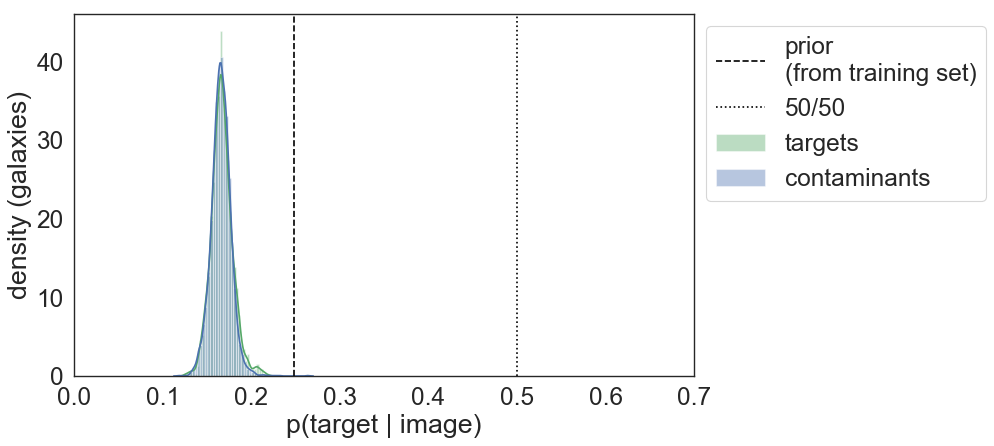

In [158]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    sns.distplot(df_testing[df_testing.target].CNN_prob, color="g", label="targets")
    sns.distplot(df_testing[~df_testing.target].CNN_prob, color="b", label="contaminants")

    plt.xlabel("p(target | image)")
    plt.ylabel("density (galaxies)")

    plt.xlim(0, .7)
    plt.axvline(df_testing.target.mean(), linestyle="dashed", color="black", label="prior\n(from training set)")
    plt.axvline(.5, linestyle="dotted", color="black", label="50/50")

    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )


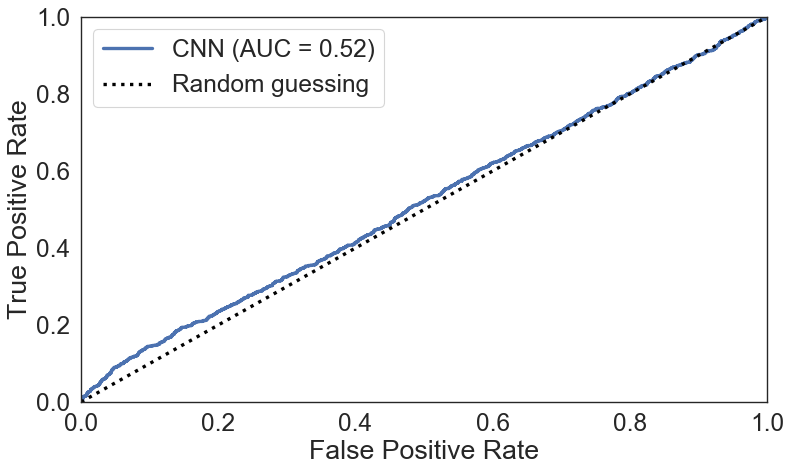

In [166]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    fpr, tpr, _ = metrics.roc_curve(df_testing.target, df_testing.CNN_prob)
    roc_auc = roc_auc_score(df_testing.target, df_testing.CNN_prob)

    plt.plot(fpr, tpr, label="CNN (AUC = {:.2})".format(roc_auc), 
             color=color_CNN, linewidth=linewidth,
            )
    plt.plot([0,1], [0,1], linestyle="dotted", color="black", label="Random guessing",
             linewidth=linewidth,
            )

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.legend(loc="best")
    
    plt.tight_layout()
    plot_filename = "plots_for_thesis/ROC-CNN"
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")


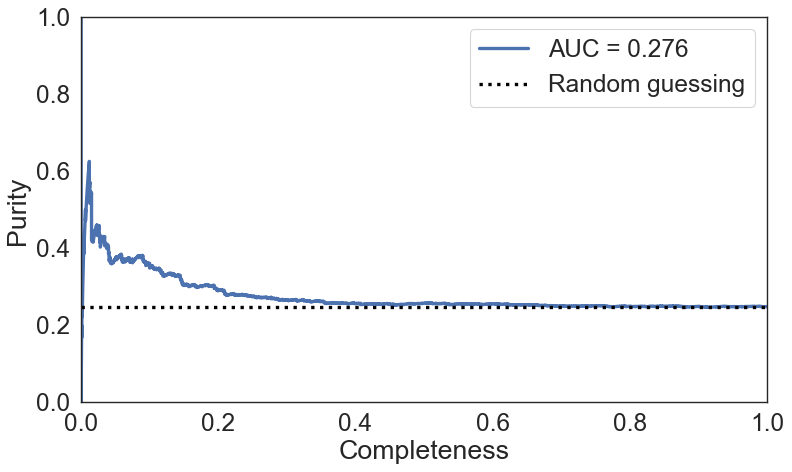

In [170]:
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    precision, recall, _ = metrics.precision_recall_curve(df_testing.target, df_testing.CNN_prob)
    pr_auc = average_precision_score(df_testing.target, df_testing.CNN_prob)

    plt.plot(recall, precision, label="AUC = {:.3}".format(pr_auc), color=color_CNN, linewidth=linewidth)
    
    plt.plot([0,1], [Y[testing_set_indices].mean()]*2, linestyle="dotted", color="black", 
             label="Random guessing",
             linewidth=linewidth,
            )


    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Completeness")
    plt.ylabel("Purity ")

    plt.legend(loc="best")
    
    plt.tight_layout()
    plot_filename = "plots_for_thesis/purity_completeness-CNN"
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")


## Apply a threshold
For now, just use a threshold using the prior class probability (estimated from the training set)

**Note** under a symmetric loss function, this isn't as good as 

In [ ]:
predicted_classes = class_probs > (Y[training_set_indices].mean())
predicted_classes.mean()

In [ ]:
confusion_matrix = metrics.confusion_matrix(Y[testing_set_indices], predicted_classes)
confusion_matrix

In [ ]:
print("number of dwarfs (true)     : ", Y[testing_set_indices].sum())
print("number of dwarfs (predicted): ", predicted_classes.sum())

In [ ]:
import itertools
# adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

plt.imshow(confusion_matrix_normalized, interpolation='nearest',cmap="gray_r")
# plt.title(title)
plt.colorbar()
tick_marks = np.arange(2)
classes = [False, True]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = 1 / 2.
for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
    plt.text(j, i, format(confusion_matrix[i, j], fmt),
             fontdict={"size":20},
             horizontalalignment="center",
             color="white" if confusion_matrix_normalized[i, j] > thresh else "black")

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [ ]:
print("  i - Y_true[i] - Y_pred[i] -  error?")
print("-------------------------------------")
for i in range(predicted_classes.size):
    print("{:>3} -    {:>1d}      -    {:d}      -   {:>2d}".format(i, 
                                                    Y[testing_set_indices][i], 
                                                    predicted_classes[i],
                                                    (Y[testing_set_indices][i] != predicted_classes[i]), 
                                                   ))

# Analyze Errors

In [ ]:
HSC_ids

In [ ]:
df.loc[HSC_ids[testing_set_indices]].head()

In [ ]:
COSMOS_filename = os.path.join(dwarfz.data_dir_default, 
                               "COSMOS_reference.sqlite")
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [ ]:
HSC_filename = os.path.join(dwarfz.data_dir_default, 
                            "HSC_COSMOS_median_forced.sqlite3")
HSC = dwarfz.datasets.HSC(HSC_filename)

In [ ]:
matches_filename = os.path.join(dwarfz.data_dir_default, 
                                "matches.sqlite3")
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [ ]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med
combined["active"]   = COSMOS.df.loc[combined.index].classification

combined = combined.set_index("catalog_2_ids")

combined.head()

In [ ]:
df_features_testing = combined.loc[HSC_ids[testing_set_indices]]

In [ ]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
# mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
#            C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Number of objects",
            )

plt.suptitle("All Objects")


In [ ]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
# mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
           C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Average Predicted\nProb. within bin",
            )


plt.suptitle("All Objects")


^^ Huh, that's a pretty uniform looking spread. It doesn't really seem like it's trending in an useful direction (either near the desired boundaries or as you go further away).

In [ ]:
df_tmp = df_features_testing.loc[HSC_ids[testing_set_indices]]
df_tmp["error"] =   np.array(Y[testing_set_indices], dtype=int) \
                  - np.array(predicted_classes, dtype=int)


mask = (df_tmp.photo_z < .5)
mask &= (df_tmp.error == -1)

print(sum(mask))

plt.hexbin(df_tmp.photo_z[mask], 
           df_tmp.log_mass[mask],
           C=class_probs,
           gridsize=20,
           cmap="Blues",
           vmin=0,
          )

plt.xlabel("photo z")
plt.ylabel("log M_star")

plt.gca().add_patch(
    patches.Rectangle([0, 8], 
                      .15, 1, 
                      fill=False, 
                      linewidth=3,
                      color="red",
                     ),
)

plt.colorbar(label="Average Predicted\nProb. within bin",
            )

plt.suptitle("False Positives")
